<a href="https://colab.research.google.com/github/qowngus33/captcha_recognition/blob/main/Captcha_model_training_and_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Nov 23 08:04:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import os
import cv2
from glob import glob
from google.colab.patches import cv2_imshow
import numpy as np

# 데이터를 불러오고 이미지 개수를 출력
data_list = glob('sample_data/samples/*.png')
len_data = len(data_list)
print(len(data_list))

1039


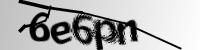

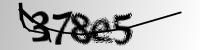

['3' '7' '8' 'e' '5']
(1039, 50, 200, 1)


In [175]:
img = cv2.imread(data_list[0], cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)

data_height = 50
data_width = 200
n_channel = 1

images = np.zeros((len_data, data_height, data_width, n_channel))
label = np.empty((len_data, 5), dtype = str)

characters = []

for n, path in enumerate(data_list):
  image = cv2.imread(data_list[n], cv2.IMREAD_GRAYSCALE) / 255   # 모델 학습을 위해 0 - 1 사이의 값으로 스케일링
  image = np.reshape(image, (data_height, data_width, n_channel)) 
  images[n, :, :, :] = image
  path = path.split('/')[2]
  path = path.split('.')[0]
  path = list(path)
  label[n] = np.array(path)
  for i in range(5):
    characters.append(path[i])

cv2_imshow(images[3] * 255)
print(label[3])
print(images.shape)

In [191]:
from string import ascii_lowercase, digits

characters = list(set(characters))
characters.sort()
#characters = list(digits) + list(ascii_lowercase)
print(characters)

['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [198]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

# 라벨링
def char_to_num(num):
  if num in characters:
    return characters.index(num)
  return None
    

num_label = np.empty((5, len_data, len(characters)), dtype = int)
for i in range(len_data):
  targs = np.zeros((5, len(characters)))
  for j, l in enumerate(label[i]):
    ind = char_to_num(l)
    targs[j, ind] = 1
    num_label[:, i] = targs

print(num_label[3][3])

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


In [199]:
import random
index_list = np.arange(len_data)
random.shuffle(index_list)
print(index_list)

# train, test split by index
for i in range(len_data):
  train_X, test_X = images[index_list[:900]], images[index_list[900:]]
  train_y, test_y = num_label[:,index_list[:900]], num_label[:,index_list[900:]]

print(len(train_X),len(test_X))
print(train_X.shape)
print(len(train_y[0]),len(test_y[0]))
print(train_y[3])

[129 252 488 ... 472 502 371]
900 139
(900, 50, 200, 1)
900 139
[[0 0 0 ... 0 0 1]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


In [200]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model

In [205]:
def create_model(num_classes):
    img = layers.Input(shape=(50, 200, 1)) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_classes, activation='sigmoid')(drop)

        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [206]:
num_classes = len(characters)
model = create_model(num_classes)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 50, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 50, 200, 16)  160         ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_18 (MaxPooling2D  (None, 25, 100, 16)  0          ['conv2d_18[0][0]']              
 )                                                                                                
                                                                                            

In [207]:
# model.fit(train_X, [train_y[0],train_y[1],train_y[2],train_y[3],train_y[4]], epochs=10, batch_size=200, verbose=2,validation_split=0.2)
hist = model.fit(train_X, [train_y[0], train_y[1], train_y[2], train_y[3], train_y[4]], batch_size=32, epochs=100,verbose=1, validation_split=0.2)

Train on 720 samples, validate on 180 samples
Epoch 1/100
704/720 [============================>.] - ETA: 0s - loss: 15.3134 - dense_48_loss: 3.0297 - dense_50_loss: 3.0959 - dense_52_loss: 3.0621 - dense_54_loss: 3.0458 - dense_56_loss: 3.0799 - dense_48_accuracy: 0.0526 - dense_50_accuracy: 0.0554 - dense_52_accuracy: 0.0696 - dense_54_accuracy: 0.0540 - dense_56_accuracy: 0.0938

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


720/720 [==============================] - 1s 2ms/sample - loss: 15.2968 - dense_48_loss: 3.0229 - dense_50_loss: 3.0909 - dense_52_loss: 3.0591 - dense_54_loss: 3.0397 - dense_56_loss: 3.0682 - dense_48_accuracy: 0.0514 - dense_50_accuracy: 0.0556 - dense_52_accuracy: 0.0694 - dense_54_accuracy: 0.0542 - dense_56_accuracy: 0.0944 - val_loss: 14.7101 - val_dense_48_loss: 2.9412 - val_dense_50_loss: 2.9437 - val_dense_52_loss: 2.9424 - val_dense_54_loss: 2.9423 - val_dense_56_loss: 2.9415 - val_dense_48_accuracy: 0.0889 - val_dense_50_accuracy: 0.0778 - val_dense_52_accuracy: 0.0833 - val_dense_54_accuracy: 0.0944 - val_dense_56_accuracy: 0.0500
Epoch 2/100
720/720 [==============================] - 0s 637us/sample - loss: 14.5949 - dense_48_loss: 2.8644 - dense_50_loss: 2.9274 - dense_52_loss: 2.9338 - dense_54_loss: 2.9380 - dense_56_loss: 2.9301 - dense_48_accuracy: 0.0972 - dense_50_accuracy: 0.0722 - dense_52_accuracy: 0.0875 - dense_54_accuracy: 0.0903 - dense_56_accuracy: 0.0792 

In [212]:
def predict_x(img):
    img = np.reshape(img, (1, 50, 200, 1))
    res = np.array(model.predict(img))
    ans = np.reshape(res, (5, num_classes))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += characters[l]
    return capt#, sum(probs) / 5

In [213]:
def print_y(y_list):
  result = ""
  for y in y_list:
    for i in range(len(y)):
      if int(y[i]) == 1:
        result += characters[i]
  return result

In [214]:
print(predict_x(test_X[0]))
print(print_y([test_y[0][0], test_y[1][0], test_y[2][0], test_y[3][0], test_y[4][0]]))

6cwwe
6cwxe


In [226]:
count = 0
for i in range(len(train_X)):
  if predict_x(train_X[i]) != print_y([train_y[0][i], train_y[1][i], train_y[2][i], train_y[3][i], train_y[4][i]]):
    count += 1

print((len(train_X)-count)/len(train_X))
print(len(train_X))

0.7611111111111111
900


p를 b로 misclassification: 72
0.9393333333333334
0.9378371237036965
0.9474735915578337
0.9378371237036965
0.9366084015720597
(19, 19)


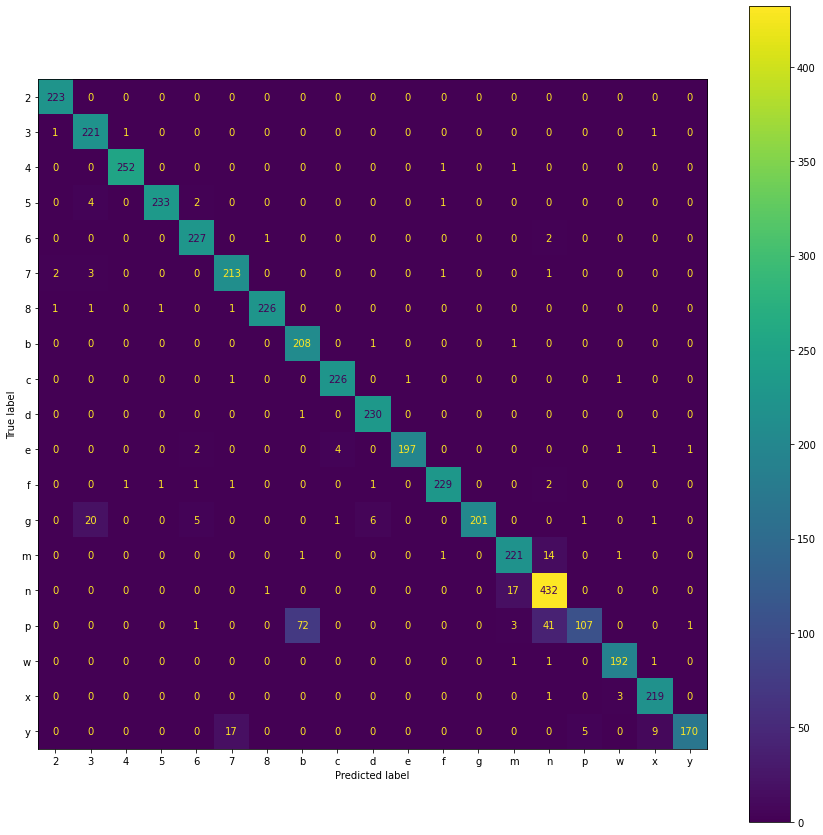

In [228]:
from sklearn import metrics
import matplotlib.pyplot as plt
count = 0
y_pred = []
y_true = []
index = []

for i in range(len(train_X)):
  predictresult = predict_x(train_X[i])
  realresult = print_y([train_y[0][i], train_y[1][i], train_y[2][i], train_y[3][i], train_y[4][i]])
  for j in range(len(predictresult)):
    y_pred.append(predictresult[j])
    y_true.append(realresult[j]) 
    if (predictresult[j] == "b") and (realresult[j] == "p"):
      index.append(i)

print("p를 b로 misclassification: " + str(len(index)))

print(metrics.accuracy_score(y_true, y_pred)) 
print(metrics.balanced_accuracy_score(y_true, y_pred)) 
print(metrics.precision_score(y_true, y_pred,average="macro"))
print(metrics.recall_score(y_true, y_pred,average="macro"))
print(metrics.f1_score(y_true, y_pred,average="macro")) 

conf_mat = metrics.confusion_matrix(y_true, y_pred) 
print(conf_mat.shape)
conf_dis = metrics.ConfusionMatrixDisplay(conf_mat, display_labels=characters)
fig, ax = plt.subplots(figsize=(15, 15))
conf_dis.plot(ax = ax)

# 선 없애기


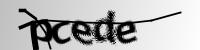

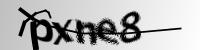

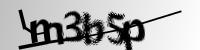

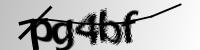

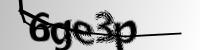

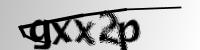

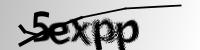

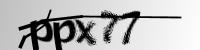

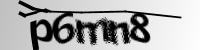

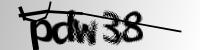

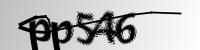

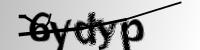

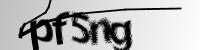

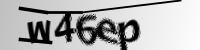

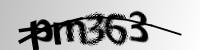

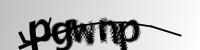

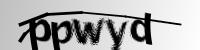

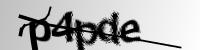

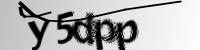

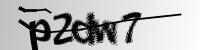

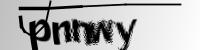

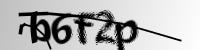

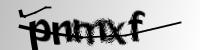

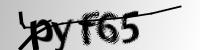

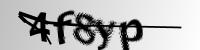

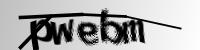

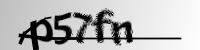

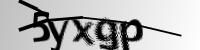

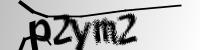

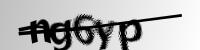

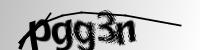

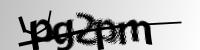

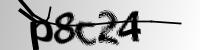

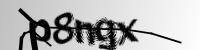

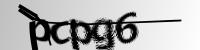

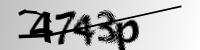

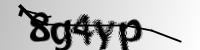

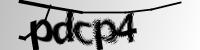

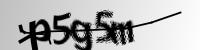

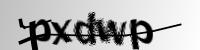

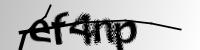

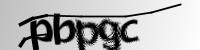

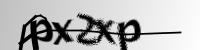

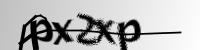

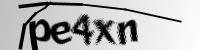

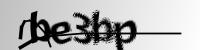

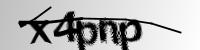

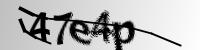

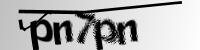

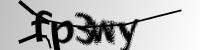

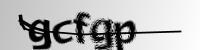

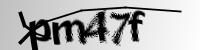

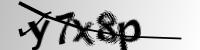

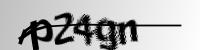

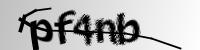

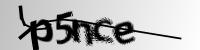

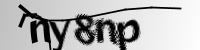

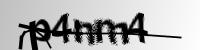

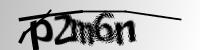

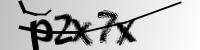

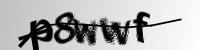

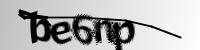

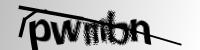

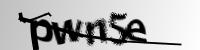

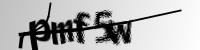

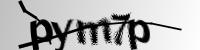

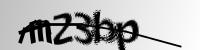

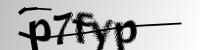

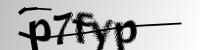

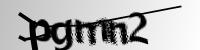

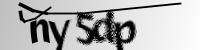

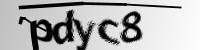

In [229]:
# p를 b로 misclassification한 경우
for i in range(len(index)):
  cv2_imshow(train_X[index[i]] * 255)